<ipython-input-3-a6239752f9b4>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfm['__date'] = pd.to_datetime(dfm[date_col], errors='coerce')


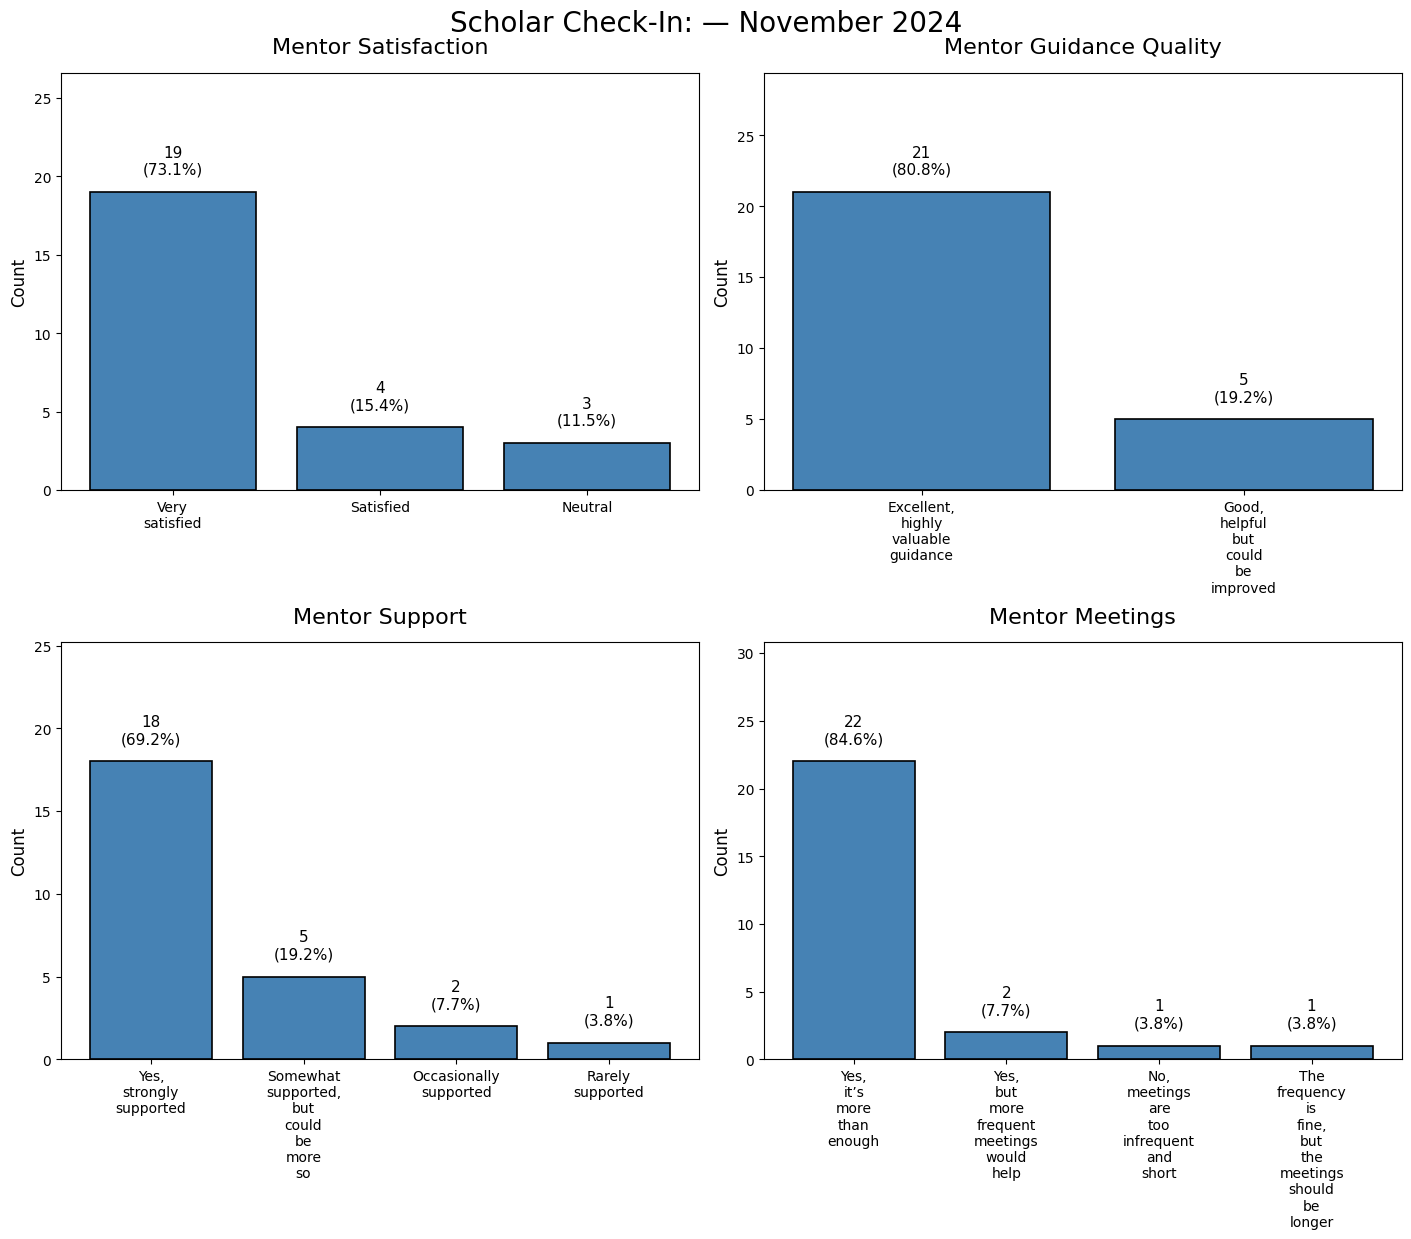

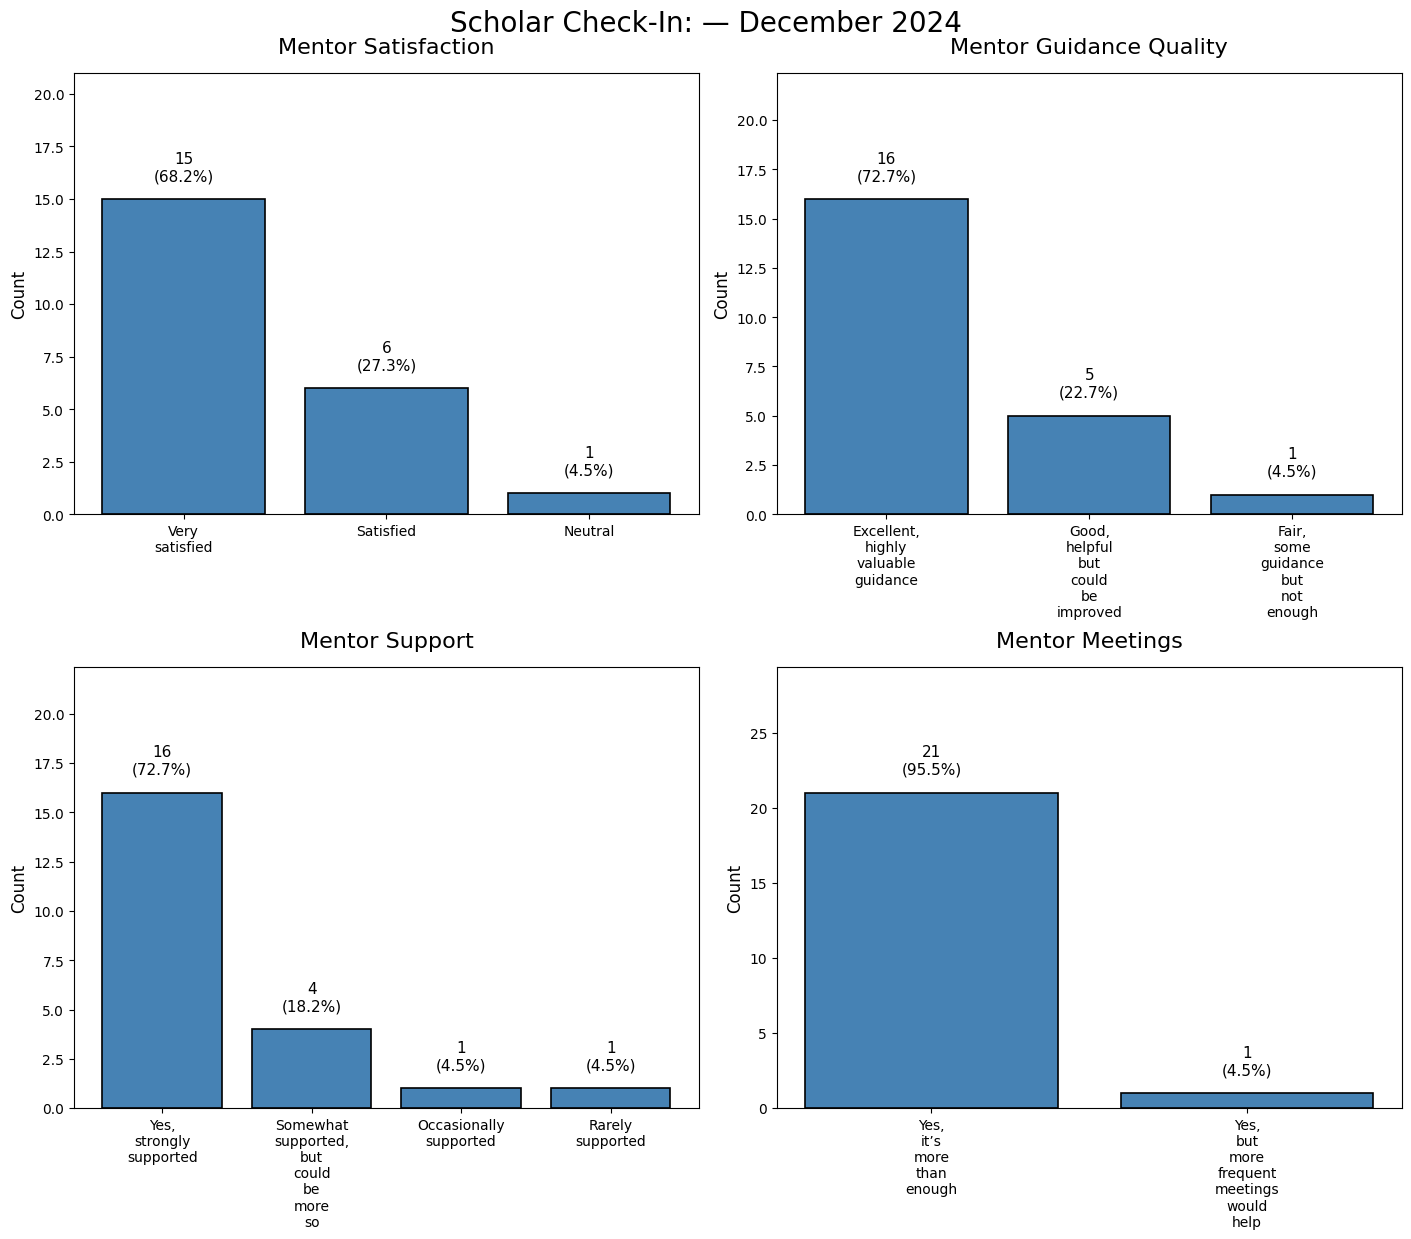

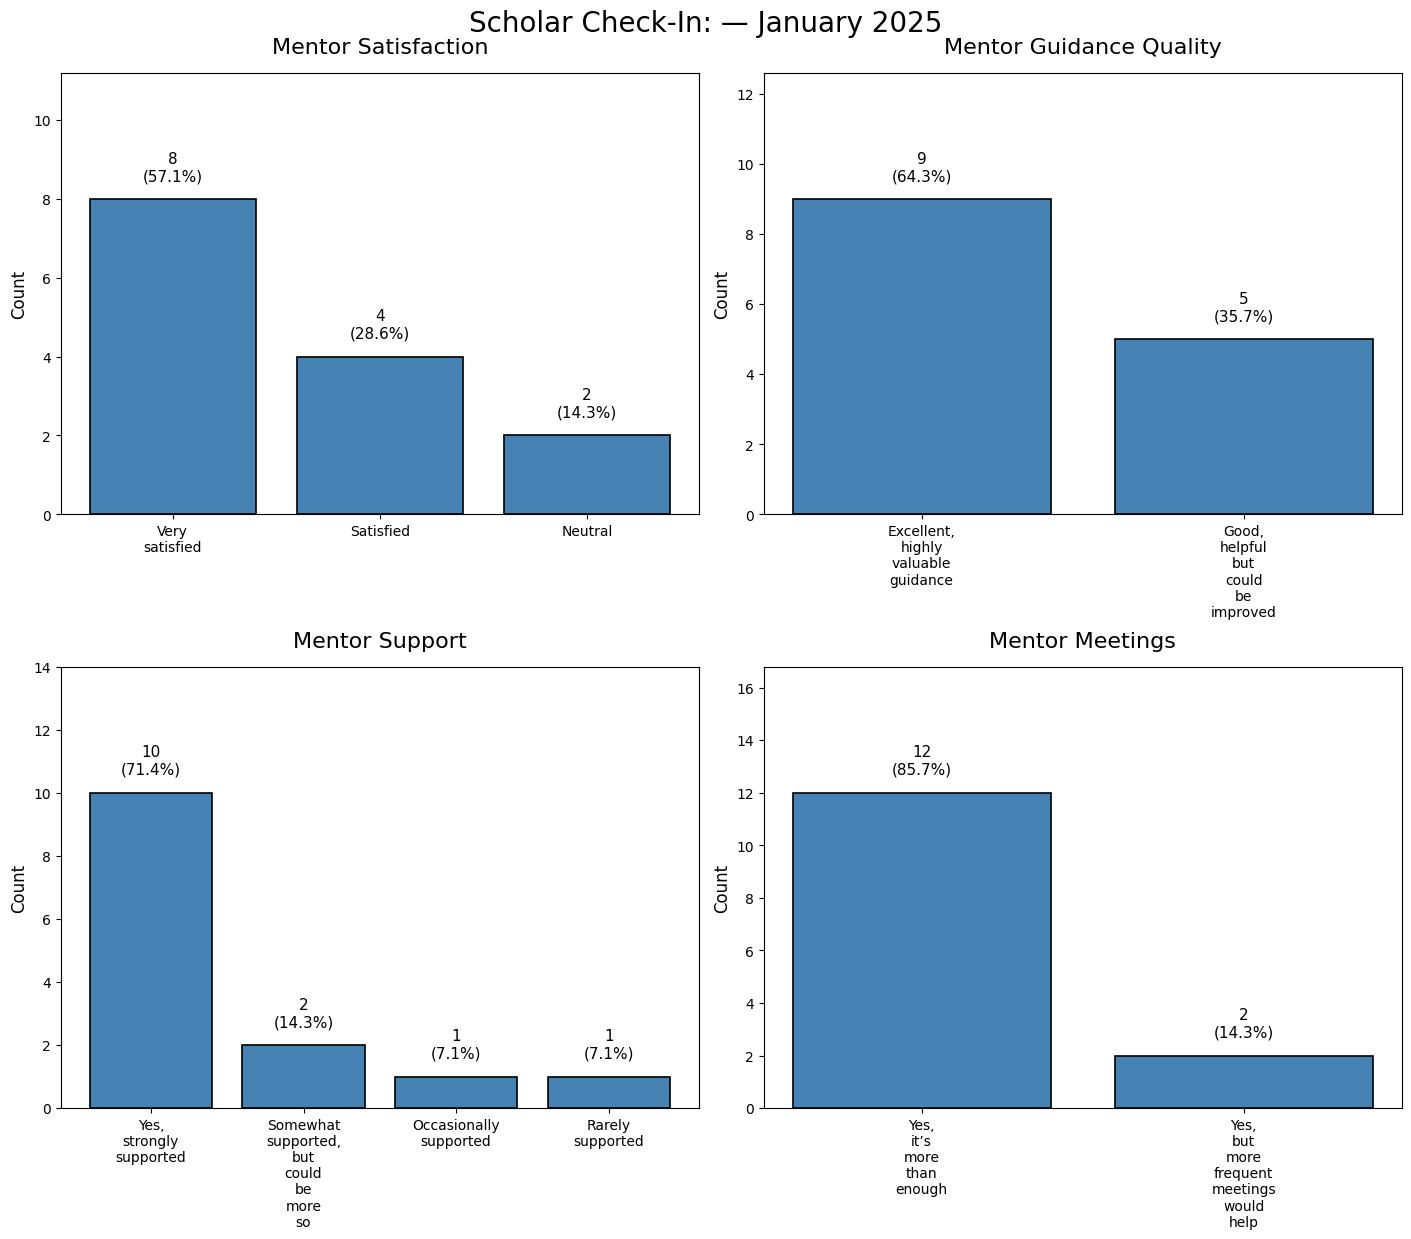

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1) Auto‐detect the four monthly CSV files
files = []
for month_name in ['november','december','january','february']:
    match = next((fn for fn in os.listdir() if month_name in fn.lower() and fn.lower().endswith('.csv')), None)
    if not match:
        raise FileNotFoundError(f"Could not find CSV for {month_name}")
    files.append(match)

# 2) Read and tag by Month
df_list = []
for fn in files:
    dfm = pd.read_csv(fn)
    date_col = next((c for c in dfm.columns if 'creat' in c.lower()), dfm.columns[0])
    dfm['__date'] = pd.to_datetime(dfm[date_col], errors='coerce')
    dfm['Month'] = dfm['__date'].dt.to_period('M').dt.to_timestamp()
    df_list.append(dfm)
df = pd.concat(df_list, ignore_index=True)

# 3) Locate Section 3 metrics dynamically
col_sat      = next(c for c in df.columns if c.startswith('3.1'))
col_guidance = next(c for c in df.columns if c.startswith('3.2'))
col_support  = next(c for c in df.columns if c.startswith('3.3'))
col_meets    = next(c for c in df.columns if c.startswith('3.4'))

metrics = {
    col_sat:      'Mentor Satisfaction',
    col_guidance: 'Mentor Guidance Quality',
    col_support:  'Mentor Support',
    col_meets:    'Mentor Meetings'
}

# 4) Plot each month with generous headroom and spacing
months = sorted(df['Month'].dropna().unique())
for month in months:
    mdf = df[df['Month'] == month]

    fig, axes = plt.subplots(2,2,
                             figsize=(14,12),
                             constrained_layout=True)
    axes = axes.flatten()

    for ax,(col,title) in zip(axes,metrics.items()):
        counts = mdf[col].value_counts()
        total  = counts.sum()
        max_cnt = counts.max()

        bars = ax.bar(
            range(len(counts)), counts.values,
            color='steelblue', edgecolor='black', linewidth=1.2
        )

        # Extend y‐axis for annotations
        ax.set_ylim(0, max_cnt*1.4)

        # Annotate
        for i,(bar,cnt) in enumerate(zip(bars,counts.values)):
            pct = cnt/total*100
            ax.text(
                bar.get_x()+bar.get_width()/2,
                cnt + max_cnt*0.05,
                f"{cnt}\n({pct:.1f}%)",
                ha='center', va='bottom', fontsize=11,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
            )

        # Wrapped x‐labels
        labels = [lbl.replace(' ', '\n') for lbl in counts.index]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=0, ha='center', fontsize=10)

        ax.set_title(title, fontsize=16, pad=14)
        ax.set_ylabel('Count', fontsize=12)
        ax.tick_params(axis='y', labelsize=10)

    fig.suptitle(f"Scholar Check‑In: — {month.strftime('%B %Y')}",
                 fontsize=20, y=1.02)
    plt.show()
